# A slightly more advanced tour of Chainer

A collection of notes for using chainer with CNNs.

#### Prerequisites : [CS231N notes](http://cs231n.github.io/convolutional-networks)  and the [chainer tutorials](http://docs.chainer.org/en/stable/tutorial/index.html)

Python and chainer versions being used

In [1]:
from chainer import __version__
from sys import version

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5103)


In [2]:
print("Python Version:{}\n\nChainer version:{}".format(version,__version__))

Python Version:3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

Chainer version:1.19.0


## Section: MNIST
### Part 1:  Simple CNN 1



Chainer ethos: **Chain** *links* and *functions* to build model

###### Main components

**Variable**: An array that tracks computations applied on it (i.e. a numpy array with a structure that supports backpropagation).  
**Functions**: carry out predefined mathematical operations on Variables.  
**Links**: are functions with (trainable) parameters (i.e. weights).  
**Chains**: are collections of links (and functions).

In [3]:
from chainer import Chain
import chainer.links as L

##### Define model components
First step in defining a model is to name and list all the different types of links (layers) in the model.  

Here we use a *Chain* object to hold them (for conveniance) but we could have just as easily defined them on their own (since link objects hold their own parameters and all information required to train them).  

A benefit of storing them together is that we can later iterate over the *"model_0"* Chain object and calculate things like memory usage and parameter counts

In [4]:
model_0 = Chain(conv0 = L.Convolution2D(in_channels=1, out_channels=16, ksize=3, stride=1, pad=0, wscale=1, bias=0),

                            conv1 = L.Convolution2D(16,32,3),
                            conv2 = L.Convolution2D(32, 32, 3, pad=1),
                            conv3 = L.Convolution2D(32, 32, 3, pad=1),
                            conv4 = L.Convolution2D(32, 32, 3),  
                            FC1 = L.Linear(512,100),
                            FC2 = L.Linear(100,10))

##### We could have just done this instead too
#conv0 = L.Convolution2D(in_channels=1, out_channels=16, ksize=3, stride=1, pad=0, wscale=1, bias=0)
#conv1 = L.Convolution2D(16,32,3),
#conv2 = L.Convolution2D(32, 32, 3, pad=1),
#conv3 = L.Convolution2D(32, 32, 3, pad=1),
#conv4 = L.Convolution2D(32, 32, 3),  
#FC1 = L.Linear(512,100),
#FC2 = L.Linear(100,10)

**in_channels** dimensionality of the input. (e.g. 1 for grey scale, 3 for rgb, 4 for rgba/rgb-d, etc).  
**out_channels** number of filters to use (this will be input into the *in_channels* of subsequent links).  
**ksize** filter/kernel size.    
**wscale** how much to scale the weights by 
**bias** value to initialise bias vector

##### Define Foward Pass
Create a function for the series of computations that take place during the foward pass (i.e. evaluate the network).  
Use the predefined links (in model_0) to process the incoming data.

In [5]:
import chainer.functions as F

In [6]:
def foward_0(x ,t=None, predict = False):
    l0 = model_0.conv0(x)
    l0 = F.relu(l0)    
    
    l1 = model_0.conv1(l0)
    l1 = F.relu(l1)

    l2 = model_0.conv2(l1)
    l2 = F.max_pooling_2d(F.relu(l2),2)
    
    l3 = model_0.conv3(l2)
    l3 = F.max_pooling_2d(F.relu(l3),2)

    l4 = model_0.conv4(l3)
    l4 = F.relu(l4)
    
    l5 = model_0.FC1(l4)
    l5 = F.relu(l5)
    
    l6 = model_0.FC2(l5)
    l6 = F.relu(l6)
    
    y = l6
    
    if not predict:
        return F.softmax_cross_entropy(y,t)
    
    return F.softmax(y).data.argmax(1)

**x** is the image.  
**t** is the target.  
**predict** determines whether we are training or just predicting using the current network parameters (i.e. softmax vs softmax_cross_entropy).

######  NOTE

So how do you decide on the network structure and it's hyperparametes (e.g. links/layers, filter size, ksize, etc..) ?  
Read the [cs231n notes](http://cs231n.github.io/convolutional-networks/) !!!   

The [mnist dataset](http://yann.lecun.com/exdb/mnist/), is comprised of 28x28 grey-scale images.
This makes the input to the first layer *conv0*, a 1x28x28 volume (1 for the single grey-scale channel). *conv0* outputs a 16x26x26 volume because it uses 16 distinct 3x3 filters, a padding of 0 and stride of 1 (see [cs231n notes](http://cs231n.github.io/convolutional-networks/#conv)  if this isn't obvious).  

This volume is then passed as the input to *conv1* which takes the 16-dimensional *in_channels* (relating to the 16 feature maps (channels) created by the 16 distinct filters used in *conv0*). This process is repeated for all subsequent layers in the model.    


**Input volumes ---> output volumes: for all layers**
1. **conv0**:   1x28x28     ---->      16x26x26
2. **conv1**:   16x26x26    ---->      32x24x24
3. **conv2**:   32x24x24    ---->      32x24x24
3. **MaxPool**: 32x24x24    ---->      32x12x12
4. **conv3**:   32x12x12    ---->      32x12x12
3. **MaxPool**: 32x12x12    ---->      32x6x6
5. **conv4**:   32x6x6      ---->      32x4x4
6. **FC1**:    (32x4x4)=512 ---->      100
7. **FC2**:     100         ---->      10

**Total Memory**: 59444 \* 4 bytes ~= 0.237776MB / image (only forward! ~\*2 for bwd)  
**Total Params**: 84600 parameters

#### Load training data

In [7]:
from chainer import datasets

train, test = datasets.get_mnist(ndim=2)

##### Pick an optimiser

In [8]:
from chainer import optimizers

# Setup Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model_0)

### Training Loop

Store training data in a numpy array with a suitable type (e.g. float32).

Store array as a chainer variable to enable tracking of the operations carried out on it.

In [9]:
from chainer import Variable
import numpy as np 

In [10]:
def mnist_train_0(data, test, nb_epochs = 10):
    
    for epoch in range(nb_epochs):
        print ("Current epoch: %d"%(epoch + 1))
        
        # clear gradient array
        model_0.cleargrads()

        # import subset of the data into numpy array with proper types
        subset =  [i for i in range(500)]
        x = np.array(data[subset][0]).astype(np.float32)
        y = np.array(data[subset][1]).astype(np.int32)
        
        # reshape it for chainer and cast to chainer variable
        x = x.reshape(len(subset),1,28,28)
        x = Variable(x)


        # evaluate data on model and backpropagate
        loss = foward_0(x, y)
        loss.backward()

        # update model parameters
        optimizer.update()
        
        
    
        ### evaluate on testing set ###      
        # import data into numpy array with proper types
        subset = [i for i in range(100)]  
        x = np.array(test[subset][0]).astype(np.float32)
        y = np.array(test[subset][1]).astype(np.int32)
        
        # reshape and cast to chainer variable
        x = Variable(x.reshape(len(subset),1,28,28))
        
        # evaluate test data using the current network parameters
        pred = foward_0(x,None,predict=True)
        
        # calculate accuracy
        acc = (pred == y).mean()
        print ( "Accuracy : {} \nError Rate: {}".format(acc * 100, (1-acc) * 100)) 

##### Subsets
As you may have noticed, we are only using a small subset of the data. Thats because this model is not running on a GPU and thus training on the full data set will take much more time.  

##### Dataset
The [mnist dataset](http://yann.lecun.com/exdb/mnist/) is comprised of 28 by 28 images with one colour channel (i.e. grey-scale images).   
Thinking of it as numpy array, each image is a 28 x 28 array of numbers.  
Each of those numbers represent a pixel and each pixel has a value ranging from 0 to 255.  
The full dimensionality of each image is 1x28x28 corresponding to 1 grey-scale dimension for each 28x28 image.  
Chainer also takes an additional batch dimension corresponding to how many images you want to process at once. For example, an array for 128 mnist images has dimensions 128x1x28x28.

In [11]:
mnist_train_0(train,test,5)

Current epoch: 1
Accuracy : 22.0 
Error Rate: 78.0
Current epoch: 2
Accuracy : 28.999999999999996 
Error Rate: 71.0
Current epoch: 3
Accuracy : 33.0 
Error Rate: 67.0
Current epoch: 4
Accuracy : 32.0 
Error Rate: 68.0
Current epoch: 5
Accuracy : 33.0 
Error Rate: 67.0


#### Mini-batches
Taking the subset idea further, we could sample random subsets from the entire dataset and train on them each iteration.

In [12]:
def mnist_train_0_batch(data, test, batch_size = 64, nb_epochs = 10):
    
    for epoch in range(nb_epochs):
        print ("Current epoch: %d"%(epoch + 1))
       
        ## shuffle the dataset
        nb_data = len(data) - (len(data) % batch_size)
        shuffler = np.random.permutation(nb_data)
        
        for i in range(0, nb_data, batch_size):
                
            # clear or zero-out gradients
            model_0.cleargrads()

            # import subset of the data into numpy array with proper types
            x = np.array(data[shuffler[i : i + batch_size]][0]).astype(np.float32)
            y = np.array(data[shuffler[i : i + batch_size]][1]).astype(np.int32)

            # reshape for channel depth dimension and cast to chainer variable
            x = x.reshape(batch_size,1,28,28)
            x = Variable(x)


            # evaluate data on model and backpropagate
            loss = foward_0(x, y)
            loss.backward()

            # update model parameters
            optimizer.update()
        
        

        ### evaluate on entire testing set ###
        print("Validation Set")
        # import data into numpy array with proper types
        x = np.array(test[:,][0]).astype(np.float32)
        y = np.array(test[:,][1]).astype(np.int32)
        
        # reshape and cast to chainer variable
        x = Variable(x.reshape(len(test),1,28,28))
        
        pred = foward_0(x,None,predict=True)
    
        acc = (pred == y).mean()
        print ( "Accuracy : {} \nError Rate: {}".format(acc * 100, (1-acc) * 100)) 

In [13]:
mnist_train_0_batch(train,test, nb_epochs = 1)  ## Takes a very long time

Current epoch: 1
Validation Set
Accuracy : 89.16 
Error Rate: 10.840000000000005


### GPU Usage

To use the GPU, we just need to send the model and data to it.

Additionally, we will let chainer reshape the 28x28 images into 1x28x28 images.

In [14]:
train, test = datasets.get_mnist(ndim=3) # Return the channel dimension too

In [15]:
from chainer import cuda

In [16]:
# Send the model to the gpu
gpu_id = 0
cuda.get_device(gpu_id).use()  
model_0.to_gpu()

In [17]:
def mnist_train_0_gpu(data, test, batch_size=128, nb_epochs = 10):
   
    for epoch in range(nb_epochs):
        
        print ("Current epoch: %d"%(epoch + 1))
        
        ## shuffle the dataset
        nb_data = len(data) - (len(data) % batch_size)
        shuffler = np.random.permutation(nb_data)
        
        for i in range(0, nb_data, batch_size):
            
            # clear previous gradients
            model_0.cleargrads()
            
            # import data, normalise and reshape it for batch processing
            x = np.array(data[shuffler[i : i + batch_size]][0]).astype(np.float32).reshape(batch_size,1,28,28)
            y = np.array(data[shuffler[i : i + batch_size]][1]).astype(np.int32).reshape(batch_size)  
            
            # send data arrays to gpu
            x = Variable(cuda.to_gpu(x))
            y = Variable(cuda.to_gpu(y))
            
            # evaluate data on model and backpropagate
            loss = foward_0(x,y)
            loss.backward()
            
            # update model parameters
            optimizer.update()      
        
        ### evaluate on testing set ##
        mnist_evaluation(test)

Note that for the gpu we have to ensure that the target-labels *y* are also chainer *Variables*

In [18]:
### evaluate on entire testing set ###
def mnist_evaluation(test):
        # import data into numpy array with proper types
        x = np.array(test[:,][0]).astype(np.float32)
        
        x = Variable(cuda.to_gpu(x))
        y = cuda.to_gpu(test[:,][1])
        
        pred = foward_0(x,None,predict=True)
    
        acc = (pred == y).mean()
        print ( "Accuracy : {} \nError Rate: {}".format(acc * 100, (1-acc) * 100)) 

In [19]:
mnist_train_0_gpu(train,test, nb_epochs=5)

Current epoch: 1
Accuracy : 89.45 
Error Rate: 10.550000000000004
Current epoch: 2
Accuracy : 89.44 
Error Rate: 10.560000000000002
Current epoch: 3
Accuracy : 89.18 
Error Rate: 10.819999999999997
Current epoch: 4
Accuracy : 89.42999999999999 
Error Rate: 10.570000000000002
Current epoch: 5
Accuracy : 89.39 
Error Rate: 10.609999999999998


### Visualisations

#### Dataset Visualisation

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

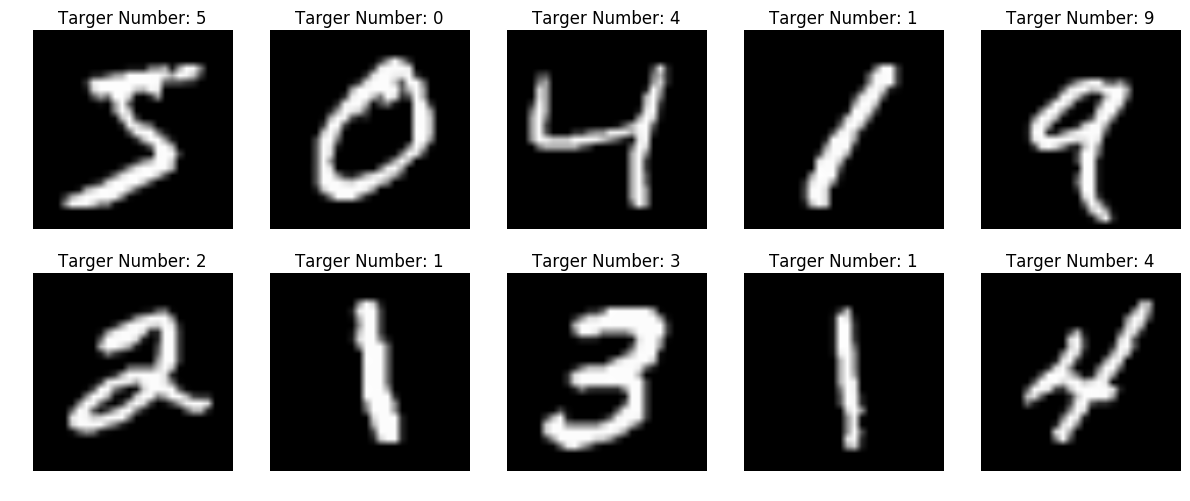

In [21]:
plt.figure(figsize=(12,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train[i][0][0],cmap="gist_gray")
    plt.title("Targer Number: {0}".format(train[i][1]))
    plt.axis("off")
plt.tight_layout()

##### Network Layout Visualisation

Lets have a look at our network layout

**Note**: in order to view the network layout, we have to have an evaluated foward pass of the network.

For visualisation puposes, we first get the model back from the GPU and then call the foward pass with a single image  

Chainer outputs the layout using the DOT language, pydot is used to construct the graph which is then displayed as png.  


In [22]:
model_0.to_cpu()

In [23]:
# import datum into numpy array with proper types
x = np.array(train[[0]][0]).astype(np.float32)
y = np.array(train[[0]][1]).astype(np.int32)

# reshape it for chainer and cast to chainer variable
x = x.reshape(1,1,28,28)
x = Variable(x)


# evaluate data on model
loss = foward_0(x, y)

In [24]:
import chainer.computational_graph as c

import pydot_ng as pd
from IPython.display import Image, display

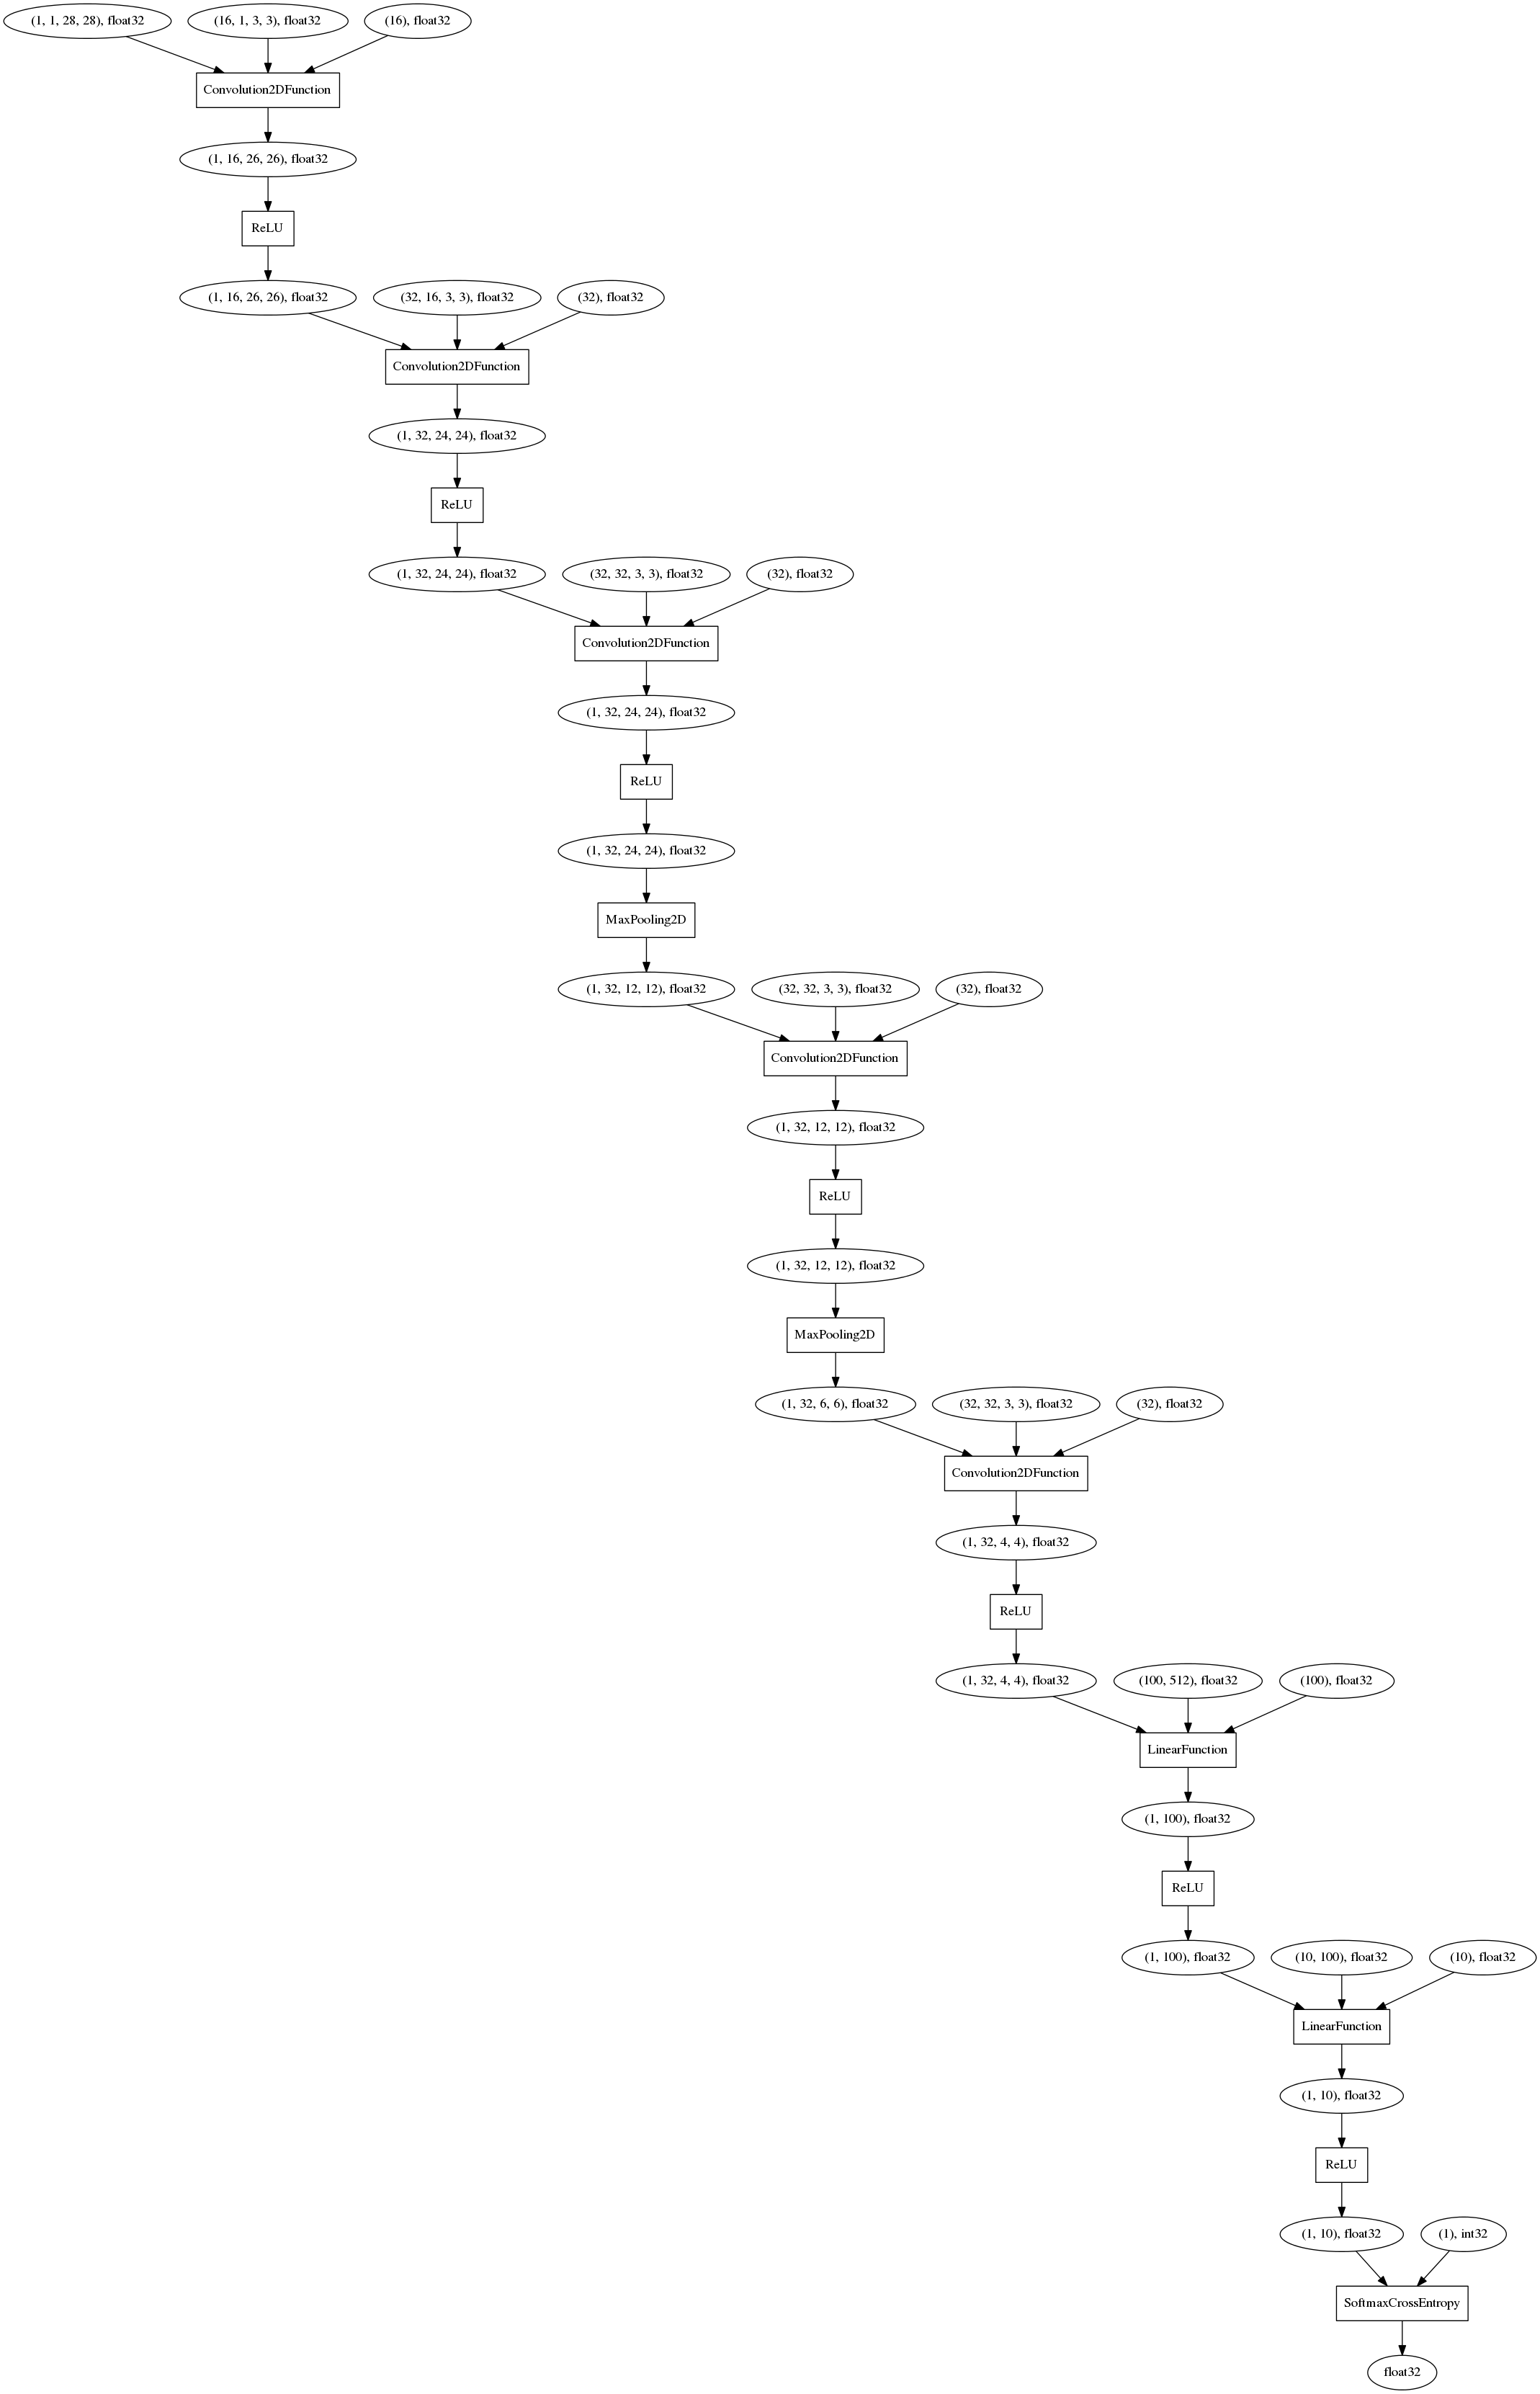

In [25]:
graph =  pd.graph_from_dot_data(c.build_computational_graph((loss,)).dump())
graph = display(Image(graph.create_png()))

### Computational Complexity
We can iterate over the child links in a chain and count the the number of parameters and storage requirements of this model.

In [26]:
def model_statistics(model):
    
    # check if model is on the gpu or cpu
    on_cpu = model._cpu
    if not on_cpu: model.to_cpu()
    
    # iterate over layers and model parameters
    count, size = 0, 0
    
    for layer in model.children():
        if layer.W is not None:
            count += layer.W.size
            size += layer.W.data.nbytes
        
        if layer.b is not None:
            count += layer.b.size
            size += layer.b.data.nbytes
            
    
    # Return model to gpu, if it was there originally
    if on_cpu != model._cpu: model.to_gpu()    
    
    return count, round(size/1048576,4)

In [27]:
stats = model_statistics(model_0)
print("Number of parameters: ",stats[0], "\nMemory usage in MiB:", stats[1])

Number of parameters:  84854 
Memory usage in MiB: 0.3237


**Note:** We didn't account for the ("254") bias weights in our first calculation but *count_model_parameters()* does. Thus the discrepency in the two calculations.

### Part 2 - Helper Functions and Model Classes

The approach taken to creating and training the model in [Part 1](#Part-1:--Simple-CNN-1) is quite cumbersome. We will keep the same model and use some of chainers helper functions that take care of the repetitive and tedious tasks so that we can focus on building interesting models.

We can clear up the internal training loop by just passing the loss function, training and test data directly to the optimizers update function. It will then automatically clear the gradient array, call the foward pass, backpropagate the error and update the model parameters

In [28]:
def mnist_train_0_gpu(data, test, batch_size=128, nb_epochs = 10):
    for epoch in range(nb_epochs):
        
        print ("Current epoch: %d"%(epoch + 1))
        
        ## shuffle the dataset
        nb_data = len(data) - (len(data) % batch_size)
        shuffler = np.random.permutation(nb_data)
        
        for i in range(0, nb_data, batch_size):
            
            # import data, normalise and reshape it for batch processing
            x = np.array(data[shuffler[i : i + batch_size]][0]).astype(np.float32)
            y = np.array(data[shuffler[i : i + batch_size]][1]).astype(np.int32) 
            
            # send data arrays to gpu
            x = Variable(cuda.to_gpu(x))
            y = Variable(cuda.to_gpu(y))
            
            # automatically calls cleargrads -> forward pass --> backward pass --> parameter update
            optimizer.update(foward_0,x,y)       
        
        ### evaluate on testing set ##
        mnist_evaluation(test)

In [29]:
model_0.to_gpu()
mnist_train_0_gpu(train,test, nb_epochs=5)

Current epoch: 1
Accuracy : 89.49000000000001 
Error Rate: 10.509999999999998
Current epoch: 2
Accuracy : 89.38000000000001 
Error Rate: 10.619999999999996
Current epoch: 3
Accuracy : 89.34 
Error Rate: 10.660000000000004
Current epoch: 4
Accuracy : 89.36 
Error Rate: 10.640000000000004
Current epoch: 5
Accuracy : 89.5 
Error Rate: 10.499999999999998


#### Model Classes
We can leavarage chainer's in-built iterators for data and training loops if the model is a callable class.

In [30]:
class SimpleCNN0(Chain):
    
    def __init__(self):
        
        super().__init__(
            conv0 = L.Convolution2D(1, 16, 3),
            conv1 = L.Convolution2D(16,32,3),
            conv2 = L.Convolution2D(32, 32, 3, pad=1),
            conv3 = L.Convolution2D(32, 32, 3, pad=1),
            conv4 = L.Convolution2D(32, 32, 3),  
            FC1 = L.Linear(512,100),
            FC2 = L.Linear(100,10)        
        )
    
    def foward(self,x):
        
        l0 = self.conv0(x)
        l0 = F.relu(l0)    

        l1 = self.conv1(l0)
        l1 = F.relu(l1)

        l2 = self.conv2(l1)
        l2 = F.max_pooling_2d(F.relu(l2),2)

        l3 = self.conv3(l2)
        l3 = F.max_pooling_2d(F.relu(l3),2)

        l4 = self.conv4(l3)
        l4 = F.relu(l4)

        l5 = self.FC1(l4)
        l5 = F.relu(l5)

        l6 = self.FC2(l5)
        l6 = F.relu(l6)
        
        return l6
    
    def __call__(self,x,t):
        
        y = self.foward(x)
        
        loss = F.softmax_cross_entropy(y,t)
        accuracy = F.accuracy(y,t)
        
        ## Model stats
        nb_params = model_statistics(self)
        
        ## Report back the loss and accuracy at every iteration
        report({'loss' : loss, 'accuracy': accuracy, 'nb_params': nb_params[0]}, self)
        
        return loss

This class implements *"model_0"* line for line, with a small change to using a chainer function for both the loss and accuracy calculation. We can use the report module (which can be called in any chain\*) to track values of interest during training. As an example, in addition to tracking the loss and accuracy, we are also tracking the model parameters using the function defined earlier.

In [31]:
model_1 = SimpleCNN0()
model_1.name =  "SimpleCNN0"

We can now import our data iterators

In [32]:
from chainer import iterators

In [33]:
batch_size = 128

train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

*train_iter* and *test_iter* are now iterators over the data. *test_iter* only iterates over the data once (repeat=false) and does not shuffle it.



Remember to setup up an optimiser and send the model to the gpu

In [34]:
## Setup optimizer
optim = optimizers.Adam()
optim.setup(model_1)
optim.use_cleargrads()

## Send to GPU
model_1.to_gpu()

We can use some of the in-built chainer objects that handle training the model and updating the parameters.

In [35]:
from chainer import training, report
from chainer.training import extensions

/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [36]:
## updater takes the data iterator, optimiser with attached model and computation device id (the gpu)
updater = training.StandardUpdater(train_iter, optim, device=gpu_id)

## trainer runs through several epochs/iterations of training
trainer = training.Trainer(updater,(5,"epoch"))

## trainer extension that evalutes on the test set
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))

Now we can just run the trainer and train on the dataset. Keep an eye on the GPU usage.

In [37]:
trainer.run()

If you analysed your gpu usage, you should have noticed that the GPU being utilised, but there was no other feedback on  how the training was progressing. To track and print network training statistics, we need to *Log* and *Print* the *report* associated with the trainer object via the use of **extensions**.  
After every training instance, we have to reinitialise the dataset iterators as they are tied to the trainer instance.

In [38]:
batch_size = 128
train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optim, device=gpu_id)
trainer = training.Trainer(updater,(5,"epoch"))
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))

## Log the report
log_report = extensions.LogReport()

## Print the report

# Here "main" refers to the target link of the "main" optimizer and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/nb_params'], log_report=log_report))

## Run trainer
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/nb_params
1           0.798707       0.797864                  84854           
2           0.798741       0.798062                  84854           
3           0.799557       0.797765                  84854           
4           0.799646       0.798457                  84854           
5           0.79949        0.798556                  84854           


We can pass the Log directly to the trainer and print out some other values (*iteration* and *elapsed_time*) that are automatically tracked by the trainer.

In [39]:
batch_size = 100
train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optim, device=gpu_id)
trainer = training.Trainer(updater,(2,"epoch"))
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))
trainer.extend(extensions.LogReport()) # passed directly to trainer

## Print the report
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'iteration' , 'main/accuracy', 'validation/main/accuracy',  'main/nb_params']))

## Run trainer
trainer.run()

epoch       elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/nb_params
1           6.68334       600         0.798849       0.7976                    84854           
2           13.2974       1200        0.799833       0.7984                    84854           


Remember that the mnist training set has 60,000 examples, and notice that the number of iterations printed above by the reporter for the first epoch is 600.  

This is because we are using a mini-batch size of 100, which means that it takes 600 calls to the models foward pass to cover the entire dataset for each epoch ( since every call passes through 100 training examples). 

The iteration counter in the reporter simply counts up how many times the training loop (models foward pass) is called during a single training session. So the iteration count for the current epoch is simply the previous iteration count plus however many iterations are carried out in the current epoch.

We can also print a progress bar after every interval of iterations.

In [40]:
batch_size = 100
train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optim, device=gpu_id)
trainer = training.Trainer(updater,(2,"epoch"))
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))
trainer.extend(extensions.LogReport()) # passed directly to trainer
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'iteration' , 'main/accuracy', 'validation/main/accuracy',  'main/nb_params']))

## Add a progress bar
trainer.extend(extensions.ProgressBar(update_interval=300))


trainer.run()

epoch       elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/nb_params
     total [############......................................] 25.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 2 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           6.67917       600         0.800166       0.7966                    84854           
     total [#########################.........................] 50.00%
this epoch [..................................................]  0.00%
       600 iter, 1 epoch / 2 epochs
    81.983 iters/sec. Estimated time to finish: 0:00:07.318568.
     total [#####################################.............] 75.00%
this epoch [#########################.........................] 50.00%
       900 iter, 1 epoch / 2 epochs
    90.408 iters/sec. Estimated time to finish: 0:00:03.318278.
2           13.3136       1200        0.799949       0.7983                    84854       

Here, we added a progress bar and set it to update every 300 iterations. For our current setup of 600 iterations per epoch, this means that we get two updates per epoch.  
Each update tells us the porportion of the total number of epochs we have covered so far and also prints out how far we are into the current epoch.  

We also get training statistics on the number of iterations processed per second and the estimated time until the current training session completes.

The reason we see 0% for every second epoch progess bar update is because the full epoch has been completed (600 iterations) and the counter has been reset before the print out.

There are alternative ways to trigger an extension (epoch, iteration and event-based triggers)   
There is an extension that takes a snapshot of the current state of the trainer instance (useful for pausing and resuming training, etc).  
And there is also a trainer extension to dump the computational graph to disk at the start of a training session (default folder is *"results"* held in *trainer.out*)

In [41]:
batch_size = 100
train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optim, device=gpu_id)
trainer = training.Trainer(updater,(2,'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))
trainer.extend(extensions.LogReport()) # passed directly to trainer
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'iteration' ,
                                       'main/accuracy', 'validation/main/accuracy',
                                       'main/loss', 'validation/main/loss',
                                       'main/nb_params']))

## Another way to trigger extensions - lazily evaluated
trainer.extend(extensions.ProgressBar(), trigger=(0.5,'epoch'))

## Take a snapshot at each epoch
trainer.extend(extensions.snapshot())

## Print the graph out to file
trainer.extend(extensions.dump_graph('main/loss'))

trainer.run()



epoch       elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  main/nb_params
     total [############......................................] 25.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 2 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           6.63292       600         0.800449       0.7961                    0.463874    0.487923              84854           
     total [#########################.........................] 50.00%
this epoch [..................................................]  0.00%
       600 iter, 1 epoch / 2 epochs
    83.195 iters/sec. Estimated time to finish: 0:00:07.211985.
     total [#####################################.............] 75.00%
this epoch [#########################.........................] 50.00%
       900 iter, 1 epoch / 2 epochs
    85.604 iters/sec. Estimated time to finish: 0:00:03.504512.
2           13.6532    

#### Custom Extensions

We can also create our own extensions by using the *make_extension()* decorator

In [42]:
from chainer.training import extension

In [43]:
@training.make_extension()
def example0(trainer):
    print("--------I am a trainer extension--------")

In [44]:
print("Default name: {} \nInvoke before training: {} \nExtention Priority: {} \nDefault Trigger: {}".format(
        example0.default_name, example0.invoke_before_training, example0.priority, example0.trigger))

Default name: example0 
Invoke before training: False 
Extention Priority: 100 
Default Trigger: (1, 'iteration')


In [45]:
batch_size = 100
train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optim, device=gpu_id)
trainer = training.Trainer(updater,(2,'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))
trainer.extend(extensions.LogReport()) # passed directly to trainer
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'iteration' ,
                                       'main/accuracy', 'validation/main/accuracy',
                                       'main/loss', 'validation/main/loss',
                                       'main/nb_params']))

#The custom extension
trainer.extend(example0,trigger=(1,'epoch'))

trainer.run()

epoch       elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  main/nb_params
1           6.67756       600         0.800766       0.7972                    0.461701    0.489235              84854           
--------I am a trainer extension--------
2           13.2104       1200        0.800899       0.7982                    0.461976    0.481202              84854           
--------I am a trainer extension--------


The *observe_value()* extension wraps up this functionality and accepts a function (and a label) to enable tracking of a value.  
*observe_lr()* tracks the learning rate of the optimiser via the use of *observe_value()*

In [46]:
def example1(trainer):
    x = model_statistics(model_1)[0] + trainer.updater.iteration
    print("Epoch progress: {} Iteration:{} x:{}, lr:{}".format(trainer.updater.epoch_detail, trainer.updater.iteration,x,
                                                       trainer.updater.get_optimizer('main').lr))
    return x

In [47]:
batch_size = 100
train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optim, device=gpu_id)
trainer = training.Trainer(updater,(2,'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model_1,device=gpu_id))
trainer.extend(extensions.LogReport())

# Observe a value throughout training
trainer.extend(extensions.observe_value("ex1",example1),trigger=(150, 'iteration'),)
trainer.extend(extensions.observe_lr())

# Exponential and linear shift modify optimiser attributes through-out training
trainer.extend(extensions.LinearShift('alpha',(0.01,0.001),(500,1000)))

# Print out recorded observation
trainer.extend(extensions.PrintReport(['elapsed_time', 'iteration' ,
                                       'main/accuracy', 'validation/main/accuracy',
                                       'main/loss', 'validation/main/loss',
                                       'ex1', 'lr']))

trainer.run()

elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  ex1         lr        
Epoch progress: 0.25 Iteration:150 x:85004, lr:0.009999675546419005
Epoch progress: 0.5 Iteration:300 x:85154, lr:0.009999720761803832
Epoch progress: 0.75 Iteration:450 x:85304, lr:0.009999759675961884
Epoch progress: 1.0 Iteration:600 x:85454, lr:0.008217830024684363
6.56112       600         0.109817       0.098                     2.28058     2.30258               85229       0.00821783  
Epoch progress: 1.25 Iteration:750 x:85604, lr:0.005517901774550813
Epoch progress: 1.5 Iteration:900 x:85754, lr:0.0028179568276179776
Epoch progress: 1.75 Iteration:1050 x:85904, lr:0.0009999868147674814
Epoch progress: 2.0 Iteration:1200 x:86054, lr:0.0009999886522273093
13.1202       1200        0.0987167      0.098                     2.3026      2.30258               85829       0.000999989  


We can also check what the trainer is tracking (or observing)

In [48]:
## Trainer observation
trainer.observation

{'ex1': 86054,
 'lr': 0.0009999886522273093,
 'main/accuracy': <variable at 0x7fdd0afb1fd0>,
 'main/loss': <variable at 0x7fdd0afb1160>,
 'main/nb_params': 84854,
 'validation/main/accuracy': array(0.09799998998641968, dtype=float32),
 'validation/main/loss': array(2.3025827407836914, dtype=float32),
 'validation/main/nb_params': 84854.0}

### Step 3 - Bringing it all together (+ hook functions)

We reset this notebook and widen it

In [49]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [50]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
from chainer import Chain, optimizers, optimizer, training, cuda, iterators, datasets, report
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

In [52]:
class SimpleCNN1(Chain):
    
    def __init__(self):
        
        super().__init__(
            conv0 = L.Convolution2D(1, 16, 3),
            conv1 = L.Convolution2D(16,32,3),
            conv2 = L.Convolution2D(32, 32, 3, pad=1),
            conv3 = L.Convolution2D(32, 32, 3, pad=1),
            conv4 = L.Convolution2D(32, 32, 3),  
            FC1 = L.Linear(512,100),
            FC2 = L.Linear(100,10)        
        )
    
    def foward(self,x):
        
        l0 = self.conv0(x)
        l0 = F.relu(l0)    

        l1 = self.conv1(l0)
        l1 = F.relu(l1)

        l2 = self.conv2(l1)
        l2 = F.max_pooling_2d(F.relu(l2),2)

        l3 = self.conv3(l2)
        l3 = F.max_pooling_2d(F.relu(l3),2)

        l4 = self.conv4(l3)
        l4 = F.relu(l4)

        l5 = self.FC1(l4)
        l5 = F.relu(l5)

        l6 = self.FC2(l5)
        l6 = F.relu(l6)
        
        return l6
    
    def predict(self, x):
        y = self.foward(x)
        return F.softmax(y).data.argmax(1)
    
    def __call__(self,x,t):
        
        y = self.foward(x)
        
        loss = F.softmax_cross_entropy(y,t)
        accuracy = F.accuracy(y,t)
        
        
        ## Report back the loss and accuracy at every iteration
        report({'loss' : loss, 'accuracy': accuracy}, self)
        
        return loss

In [53]:
model_2 = SimpleCNN1()
model_2.name = "SimpleCNN1"

We can add hooks to the optimiser that affect how it operates on gradients (e.g. weightdecay, lasso, clipping, etc)

In [54]:
opt = optimizers.Adam()
opt.setup(model_2)
opt.use_cleargrads()

## Hook into the optimizer for gradient clipping
opt.add_hook(optimizer.GradientClipping(10),'weight_decay_10')


# Send the model to the gpu
gpu_id = 0
cuda.get_device(gpu_id).use()  
model_2.to_gpu()

In [55]:
train, test = datasets.get_mnist(ndim=3)

We can also wrap the model statistics function into an extension class for the trainer.

In [56]:
from sys import stdout
class model_statistics(training.Extension):
    
    '''Sums the number of parameters in a model
    and calculates the memory usage in MiB.
    
    '''

    def model_statistics(self, model):
        
        # Check if using a classifier link
        if hasattr(model, 'predictor'):
            model = model.predictor

        # check if model is on the gpu or cpu
        on_cpu = model._cpu
        if not on_cpu: model.to_cpu()

        # iterate over layers and model parameters
        count, size = 0, 0

        for layer in model.children():
            
            if hasattr(layer, 'W'):
                count += layer.W.size
                size += layer.W.data.nbytes
                
            if hasattr(layer, 'b'):
                count += layer.b.size
                size += layer.b.data.nbytes


        # Return model to gpu, if it was there originally
        if on_cpu != model._cpu: model.to_gpu()    

        return count, round(size/1048576,4)
    
    def __call__(self, trainer, print_to_console=False, import_model = None):
        model = trainer.updater.get_optimizer('main').target
        
        if import_model is not None: model = import_model
        
        stats =  self.model_statistics(model)
        
        trainer.reporter.report({'param_count':stats[0], 'mem_usage': stats[1]},model)
        
        ## Two other alternative ways to report values
        #trainer.observation['param_count'] = stats[0]        
        #with trainer.reporter.scope(trainer.observation):
        #    report({'mem_usage': stats[1]}, model)
        
        # Print out directly to console
        if print_to_console:
            stdout.write("Number of parameters:{} \t \
                         Memory usage in MiB:{}\n".format(stats[0],stats[1]))
            stdout.flush()
        return

In [57]:
model_stats = model_statistics()

In [58]:
nb_epochs = 5
batch_size = 128

train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, opt, device=gpu_id)
trainer = training.Trainer(updater,(nb_epochs,'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model_2,device=gpu_id))
trainer.extend(model_stats)
trainer.extend(extensions.observe_lr())
trainer.extend(extensions.LinearShift('alpha',(0.001,0.0001),(9400,14000)))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'iteration' ,
                                       'main/accuracy', 'validation/main/accuracy',
                                       'main/loss', 'validation/main/loss', 'main/param_count', 'main/mem_usage', 'lr']))
trainer.extend(extensions.ProgressBar(update_interval=500))
trainer.extend(extensions.snapshot())
trainer.extend(extensions.dump_graph('main/loss'))


trainer.run()

epoch       elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  main/param_count  main/mem_usage  lr        
1           6.56134       469         0.639459       0.764537                  1.09997     0.771169              84854             0.3237          0.00061198  
     total [##########........................................] 21.33%
this epoch [###...............................................]  6.67%
       500 iter, 1 epoch / 5 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
2           13.5901       938         0.770772       0.775712                  0.770804    0.752793              84854             0.3237          0.00078024  
     total [#####################.............................] 42.67%
this epoch [######............................................] 13.33%
      1000 iter, 2 epoch / 5 epochs
    66.983 iters/sec. Estimated time to finish: 0:00:20.060990.
3           20.6545       1407        0.77570

We are now going to plot the mnist test images along with predictions from the model.

In [59]:
from chainer import Variable
import numpy as np

In [60]:
def predict_mnist(model, data, batch_size=1000):
    nb_examples = len(data)
    pred_list = []
    
    nb_data = nb_examples - (nb_examples % batch_size)
    itr_data =  list(range(nb_examples))

    for i in range(0, nb_data, batch_size):
        x = np.array(data[itr_data[i : i + batch_size]][0]).astype(np.float32)
        x = Variable(cuda.to_gpu(x))
        
        if hasattr(model, 'predict'):
            x = model.predict(x)
        else:
            x = F.softmax(model(x)).data.argmax(1)
            
        pred_list.append(x)
                
    return np.asarray(pred_list).reshape(nb_examples)

In [61]:
preds =  predict_mnist(model_2,test)

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_predictions(data, pred, start = 0):
    plt.figure(figsize=(12,5))
    
    for i in range(start, start + 10):
        plt.subplot(2,5,(i%10)+1)
        plt.imshow(data[i][0][0],cmap="gist_gray")
        plt.title("Target: {0} - Pred: {1}".format(data[i][1],pred[i]))
        plt.axis("off")
    plt.tight_layout()

Plot any set of 10 images for the test set along with their targets and the prediction results

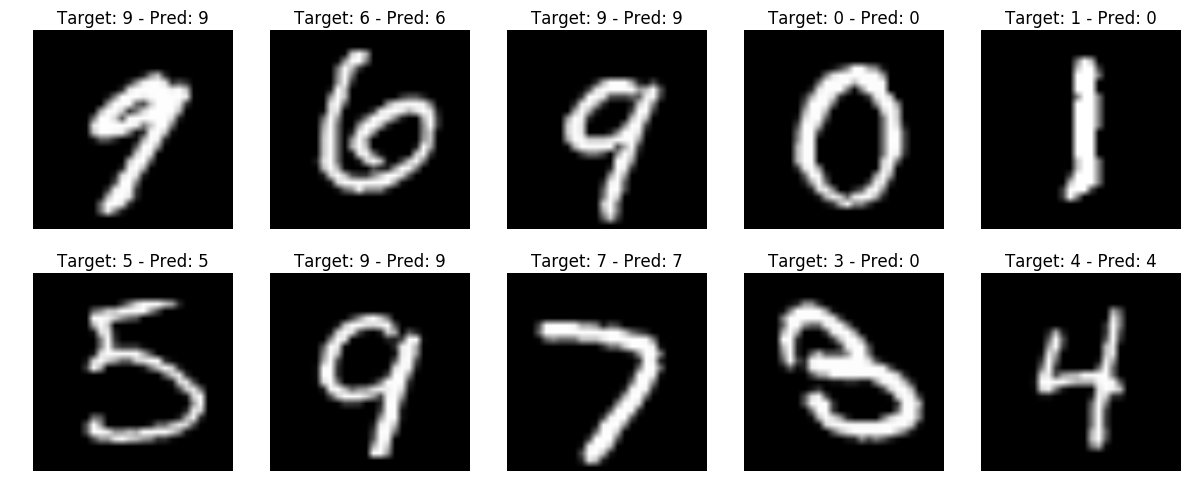

In [63]:
plot_predictions(test, preds, 11)

We will also create some functions to load, display, print and save the network structure.

In [64]:
import chainer.computational_graph as c

import pydot_ng as pd
from IPython.display import Image, display

def network_struct_from_dot(name, toPNG = False):   
    graph = pd.graph_from_dot_file(name + '.dot')
    
    if toPNG:
        graph.write_png(name + '.png')    
 
    display(Image(graph.create_png()))

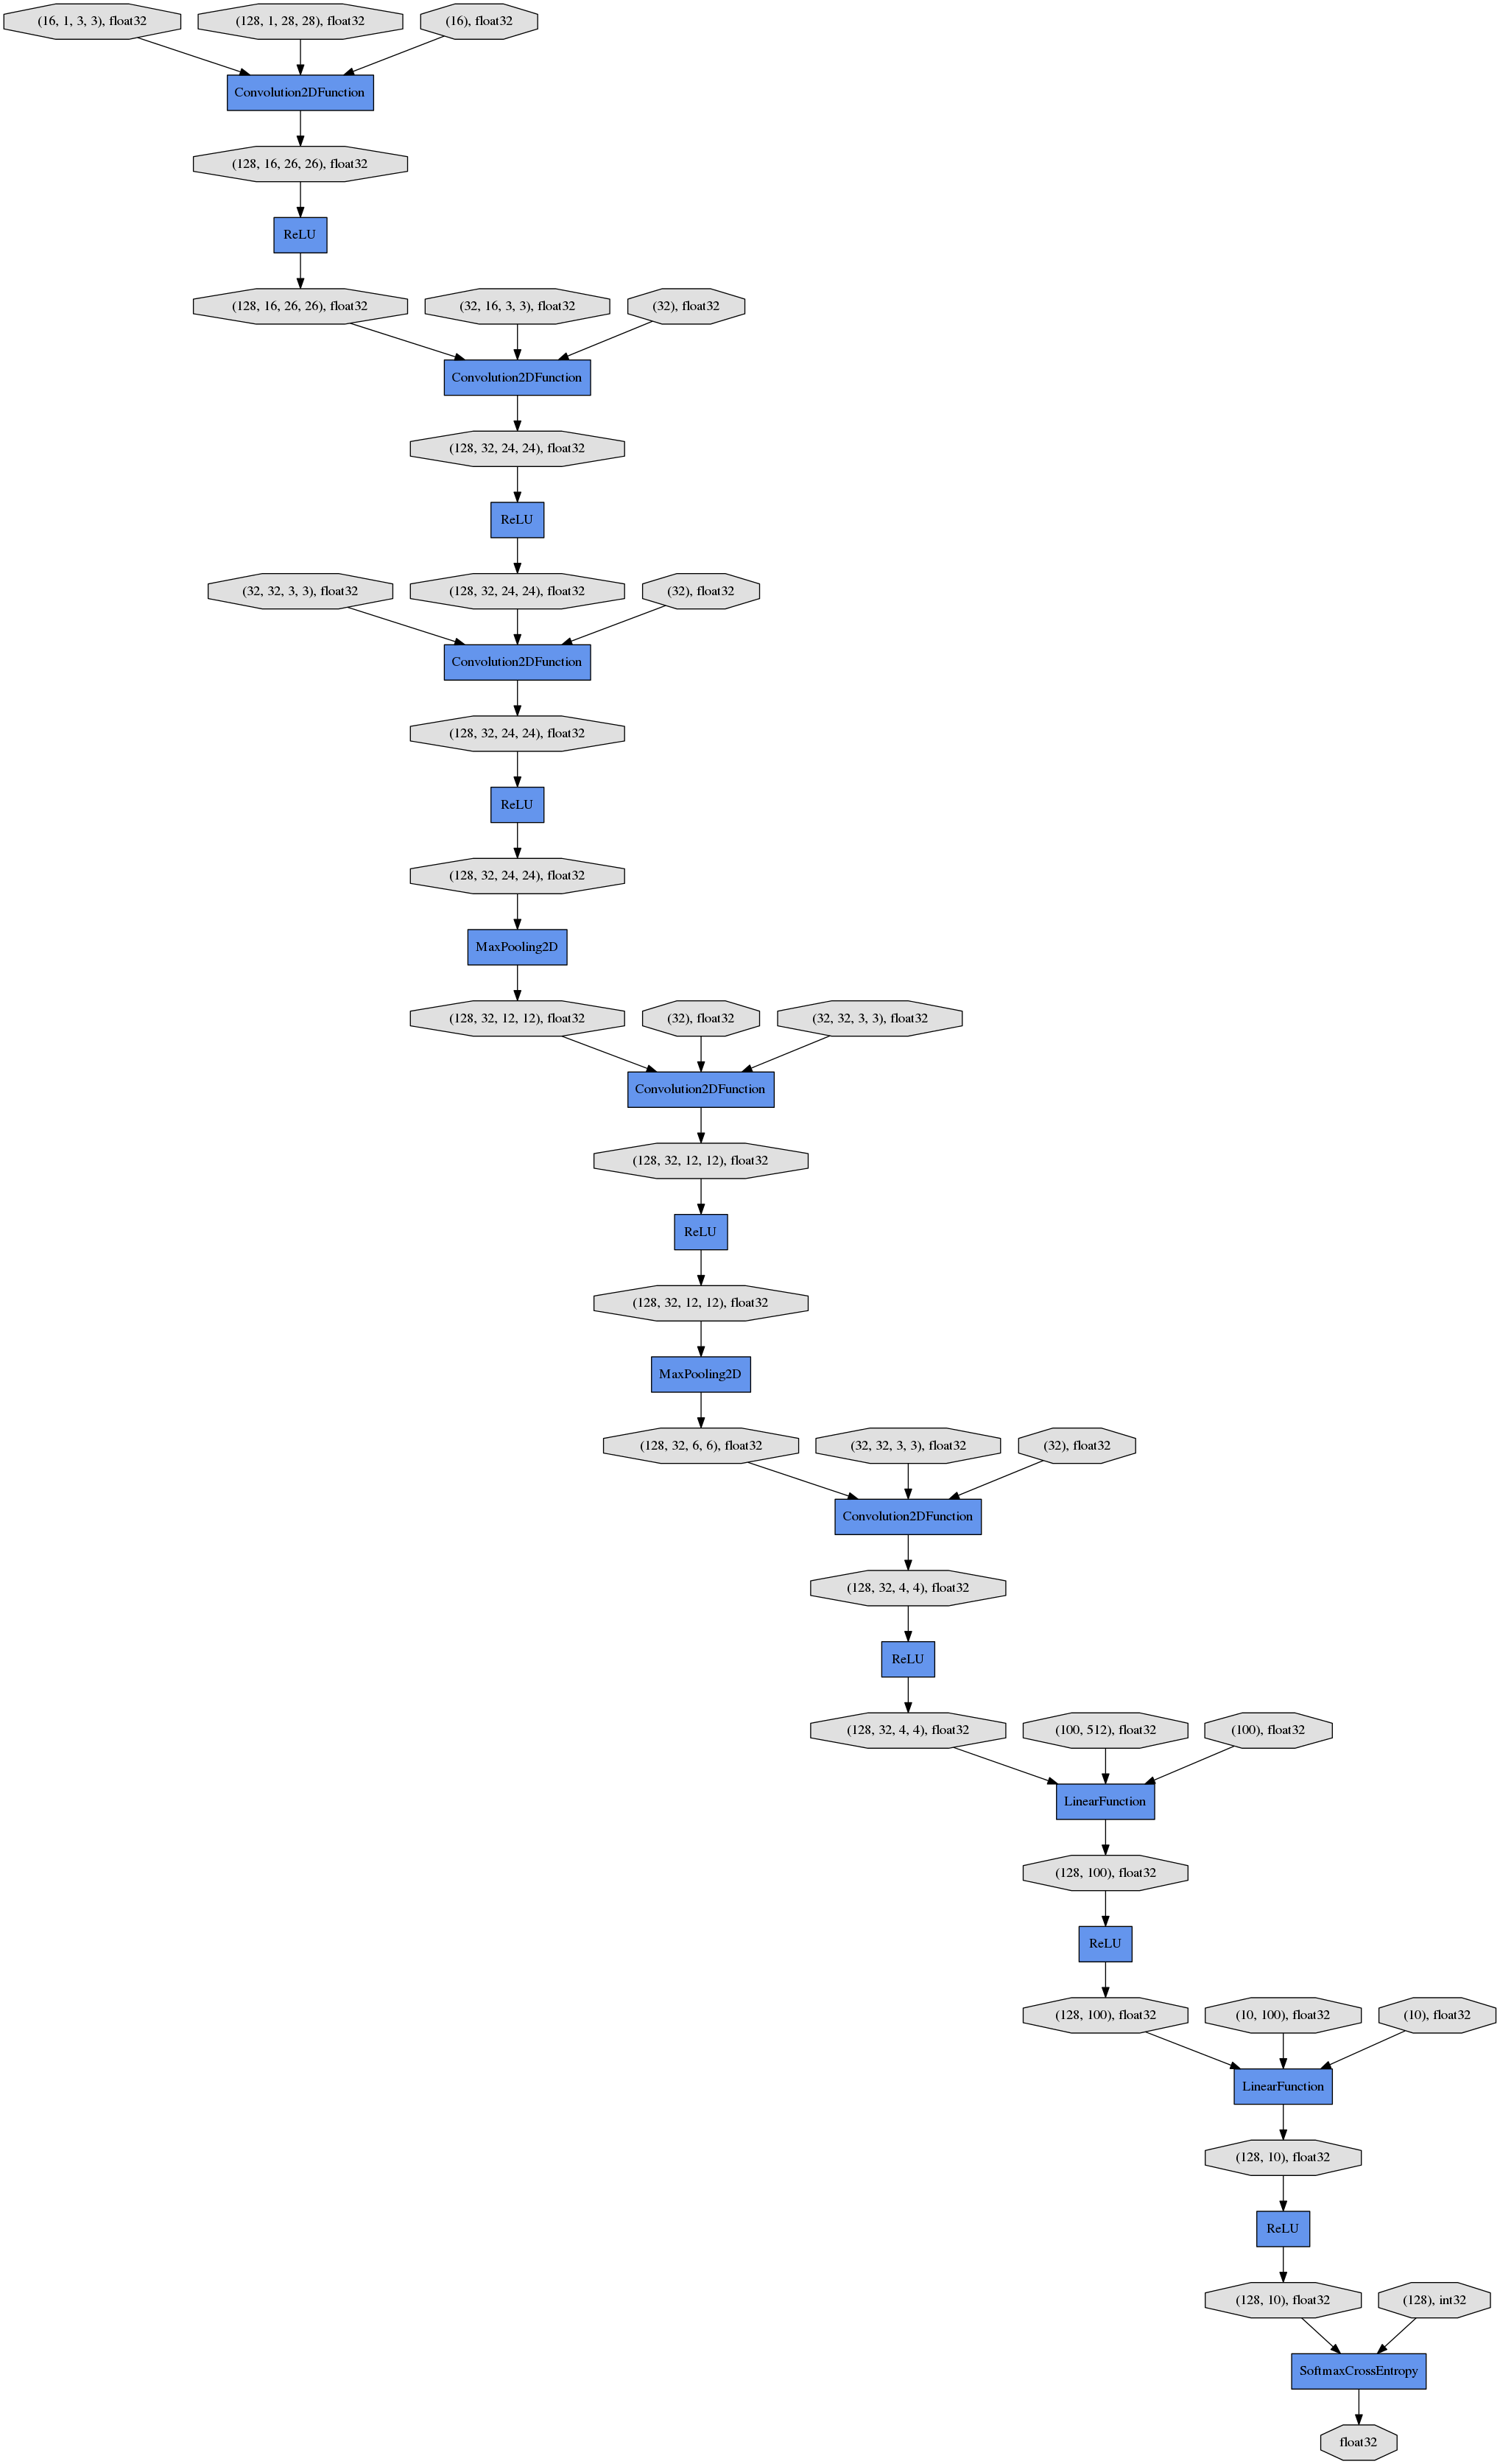

In [65]:
network_struct_from_dot(trainer.out + '/cg',toPNG=True)

In [66]:
def print_network_mnist(model, data, toBook=False, toPNG=False, toDot=False):
    
    x = Variable(cuda.to_gpu((data[0][0]).reshape(1,1,28,28)))
    y = Variable(cuda.to_gpu((data[0][1]).reshape(1)))
    
    loss = model(x,y)
    
    cg = c.build_computational_graph((loss,)).dump()
    
    if toBook:
        g =  pd.graph_from_dot_data(cg)
        g = display(Image(g.create_png()))
        
    if toDot:
        with open(model.name + '.dot', 'w') as o:
            o.write(cg)
            
    if toPNG:
        g =  pd.graph_from_dot_data(cg)
        g.write_png(model.name + '.png')

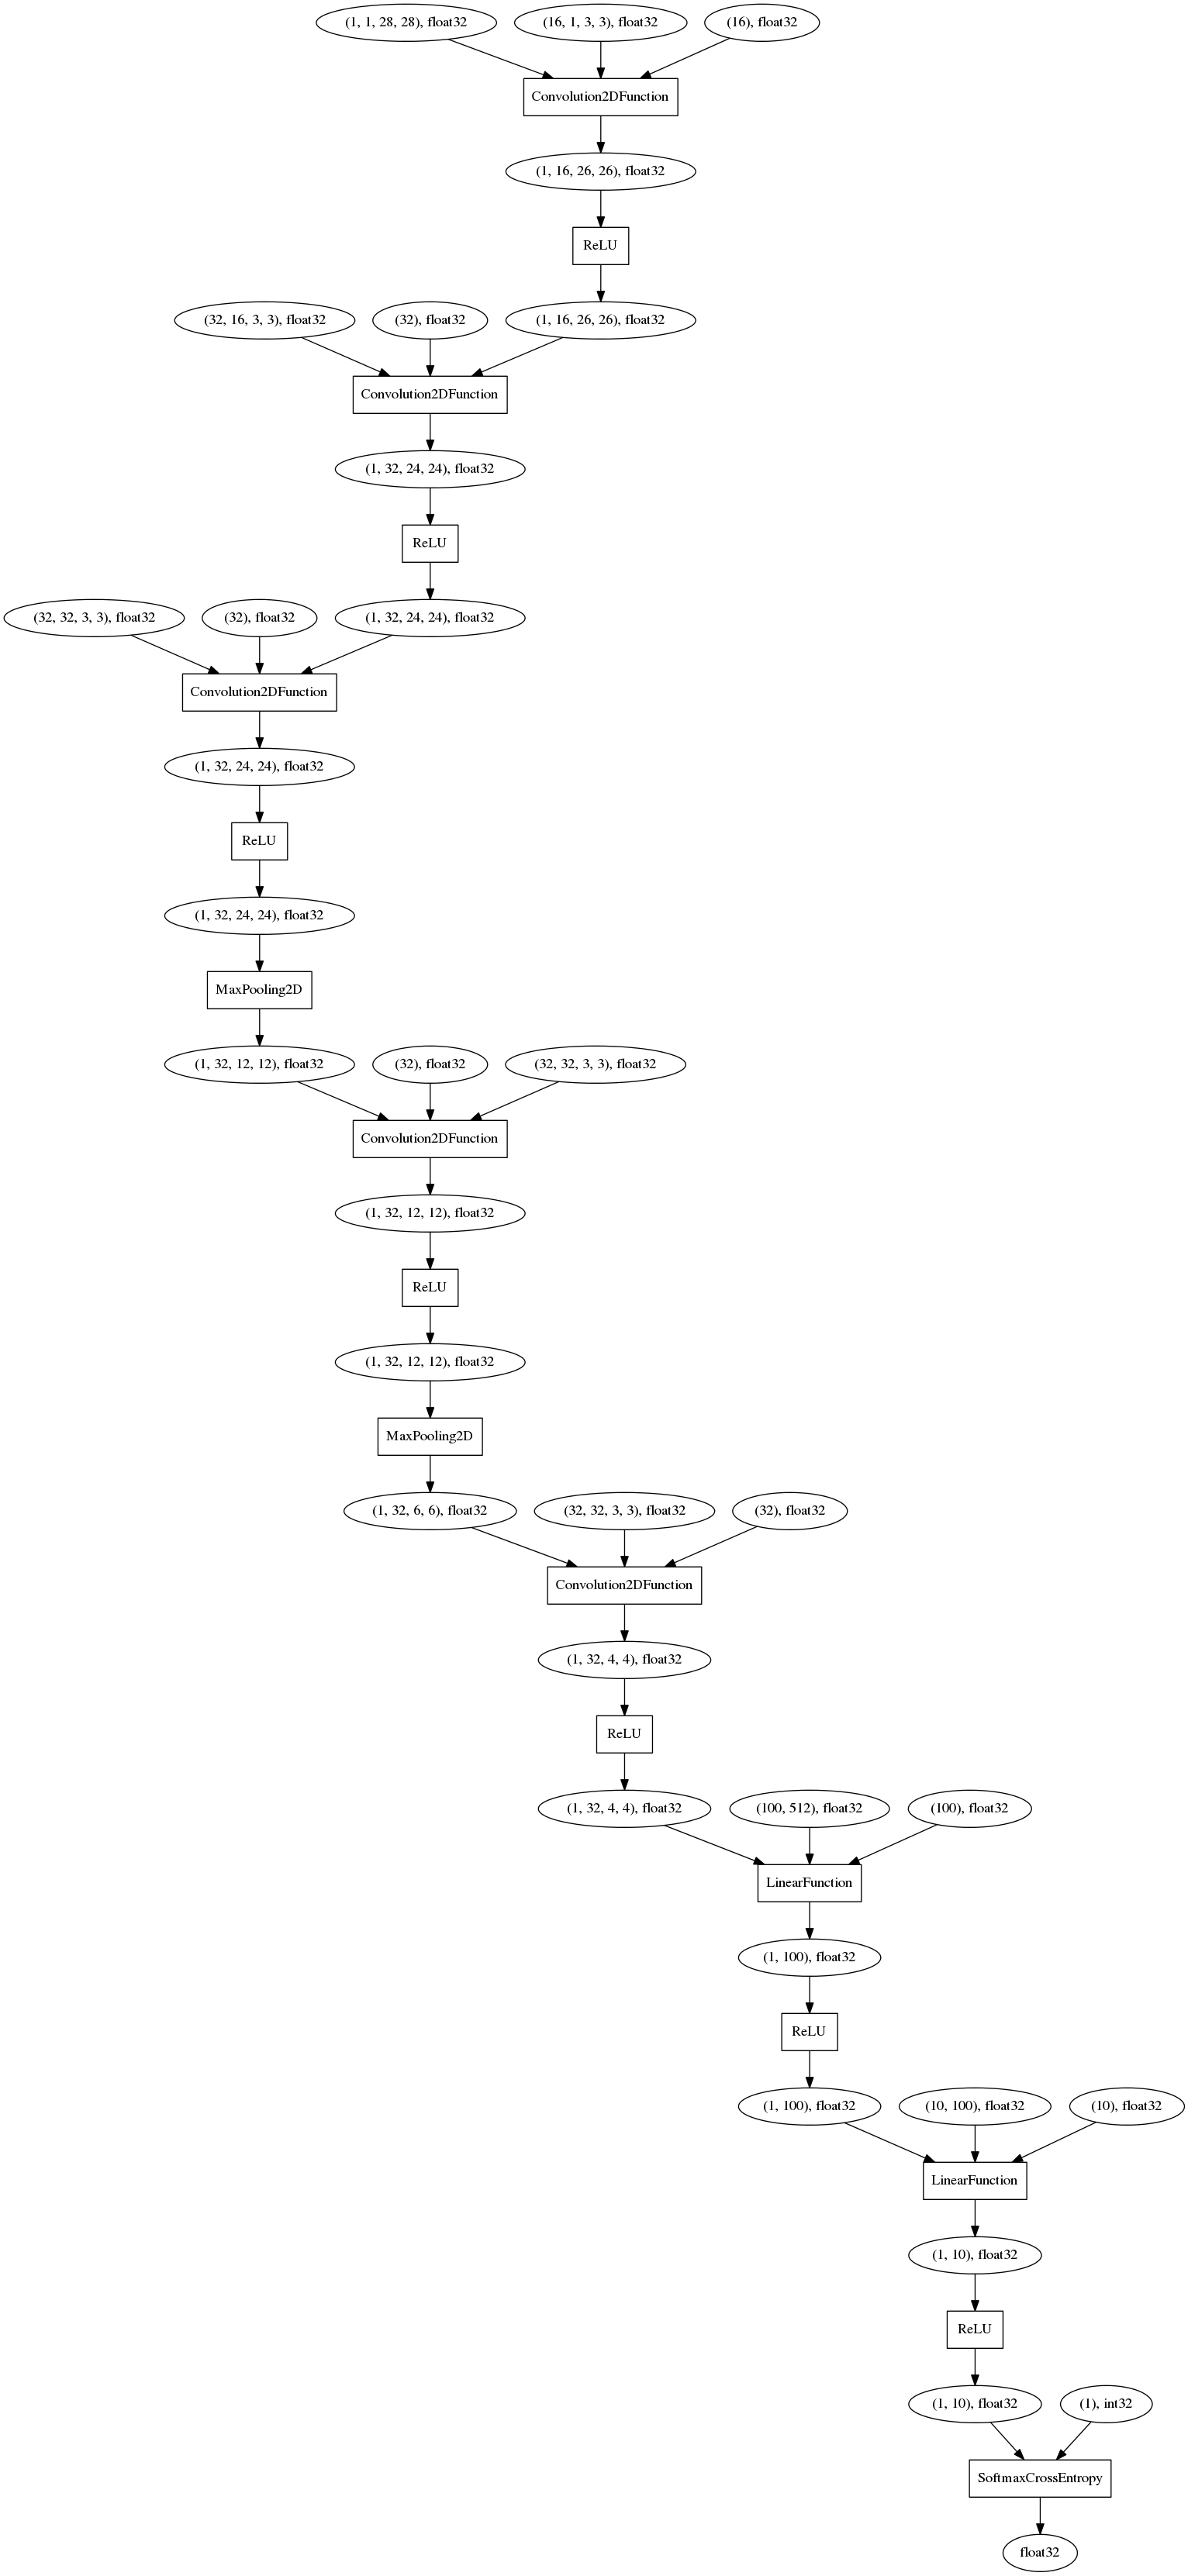

In [67]:
print_network_mnist(model_2, train, toBook=True, toDot=True, toPNG=True)

### Part 4 - Simple Fully-Convolutional CNN (+ logging and function hooks)

The [cs231n notes](http://cs231n.github.io/convolutional-networks/#fc) detail how to convert the fully connected layers in a CNN to convolutional layers.  
We add this modification and batch_normalisation to the model.

In [68]:
from chainer import initializers

We can choose how we want to initialise the weights and their precision

In [69]:
class SimpleFCNN(Chain):
    
    def __init__(self):
        
        W_scale = 0.25
        W_dtype = np.float32
        
        super().__init__(
            
            conv0 = L.Convolution2D(1, 16, 3, 
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),

            conv1 = L.Convolution2D(in_channels=16,out_channels=32,ksize=3,stride=1,pad=0,
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),


            conv2 = L.Convolution2D(32, 32, 3,
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),

            conv3 = L.Convolution2D(32, 32, 3,pad=1,
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),

            conv4 = L.Convolution2D(32, 32, 3,pad=1,
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),

            conv5 = L.Convolution2D(32,32,3,
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),

            conv6 = L.Convolution2D(32,10,1,
                                    initialW=initializers.HeNormal(W_scale, W_dtype),
                                    initial_bias=initializers.Zero(W_dtype)),

            bn0 = L.BatchNormalization(16, dtype=W_dtype),
            bn1 = L.BatchNormalization(32, dtype=W_dtype),
            bn2 = L.BatchNormalization(32, dtype=W_dtype),
            bn4 = L.BatchNormalization(32, dtype=W_dtype)            
        )
        
    def foward(self, x):
        l1 = F.relu(self.bn0(self.conv0(x)))
        l2 = F.relu(self.bn1(self.conv1(l1)))
        l3 = F.max_pooling_2d(F.relu(self.bn2(self.conv2(l2))),2)
        l4 = F.max_pooling_2d(F.relu(self.conv3(l3)),2)
        l5 = F.max_pooling_2d(F.relu(self.bn4(self.conv4(l4))),2)
        l6 = F.relu(self.conv5(l5))
        y = self.conv6(l6)

        #print(np.shape(y.data))
        #print(y.data)

        y = F.squeeze(y,axis=(2,3))
        return y
    
    def __call__(self, x):
        return self.foward(x)

There is a chainer link for classification that reports back the loss and accuracy. It takes and stores a given chain as it's *predictor*.

In [70]:
model_3 = SimpleFCNN()

model_3_classify = L.Classifier(model_3)
model_3_classify.name = "SimpleFCNN"

In [71]:
opt = optimizers.Adam()
opt.setup(model_3_classify)
opt.use_cleargrads()

opt.add_hook(optimizer.GradientClipping(10),'weight_decay_10')
#opt.add_hook(chainer.optimizer.GradientNoise(0.000001))


gpu_id = 0
cuda.get_device(gpu_id).use()  
model_3_classify.to_gpu()

Chainer includes event-based triggers that fire when a tracked value hits a new optimum. For example, this can be used to track the minimum error rate throughout training.

In [72]:
from chainer.training import triggers

In [73]:
@training.make_extension()
def best_so_far(trainer):
    acc = trainer.observation['validation/main/accuracy']
    print('Error Rate:',  ((1 - acc) * 100))

Observations from the trainer can be graphed by the *PlotReport()* extension.

In [74]:
def graph_loss(figure, axes, summary):
    axes.set_xlabel('iteration')
    axes.set_ylabel('loss')
    #axes.set_ylim((0, 0.05))
    axes.legend(loc='best')
    
def graph_acc(figure, axes, summary):
    axes.set_xlabel('iteration')
    axes.set_ylabel('accuracy')
    #axes.set_ylim((0.8, 1.0))
    axes.legend(loc='best')

In [75]:
nb_epochs = 20
batch_size = 100

train_iter = iterators.SerialIterator(train,batch_size)
test_iter = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, opt, device=gpu_id)
trainer = training.Trainer(updater,(nb_epochs,'epoch'))
trainer.extend(extensions.Evaluator(test_iter, model_3_classify,device=gpu_id))
trainer.extend(model_stats)
trainer.extend(extensions.observe_lr())
trainer.extend(extensions.LinearShift('alpha',(0.001,0.0001),(3500,5000)))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'iteration' ,
                                       'main/accuracy', 'validation/main/accuracy',
                                       'main/loss', 'validation/main/loss', 'main/param_count', 'main/mem_usage', 'lr']))
trainer.extend(extensions.ProgressBar(update_interval=500))

max_trig = triggers.MaxValueTrigger('validation/main/accuracy')
trainer.extend(best_so_far,trigger=max_trig)
trainer.extend(extensions.snapshot(filename='SimpleFCNN_snapshot_iter_{.updater.iteration}.npz'), trigger=(500,'iteration'))

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                                     file_name= model_3_classify.name +'_loss.png', postprocess=graph_loss))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                                     file_name= model_3_classify.name +'_accuracy.png', postprocess=graph_acc))

trainer.extend(extensions.dump_graph('main/loss'))


trainer.run()

epoch       elapsed_time  iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  main/param_count  main/mem_usage  lr        
     total [##................................................]  4.17%
this epoch [#########################################.........] 83.33%
       500 iter, 0 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           11.2097       600         0.960399       0.9886                    0.183577    0.0358265             42122             0.1607          0.000671828  
Error Rate: 1.1400043964385986
     total [####..............................................]  8.33%
this epoch [#################################.................] 66.67%
      1000 iter, 1 epoch / 20 epochs
    51.218 iters/sec. Estimated time to finish: 0:03:34.768502.
2           22.6179       1200        0.988515       0.9922                    0.0369487   0.0288515             42122             0.1607          0.000836054  
Error Rate

As can be observed from the *param_count* and *mem_usage* trackers, by using a Fully-Convolutional network (FCN) we have more than halfed the number of parameters and memory usage with little to no loss in performance.

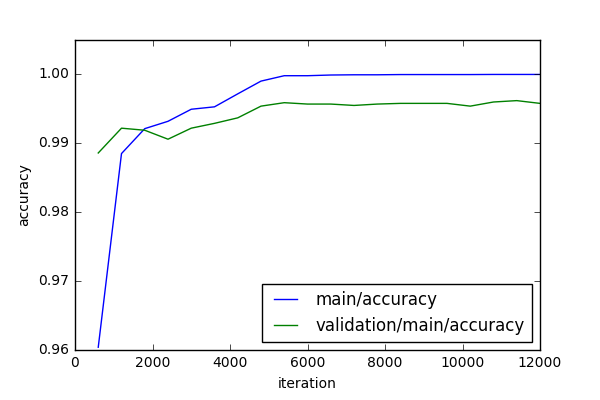

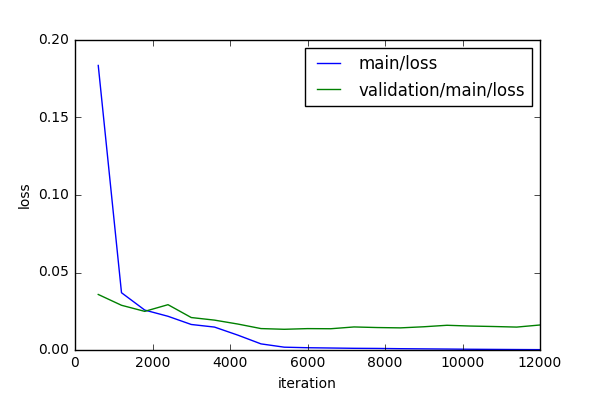

In [76]:
gl = Image(filename='result/' + model_3_classify.name + '_loss.png')
ga = Image(filename='result/' + model_3_classify.name + '_accuracy.png')
display(ga,gl)

The lowest error during training was 

In [77]:
(1-max_trig._best_value)*100

0.3800034523010254

In [78]:
model_stats(trainer,True,model_3)

Number of parameters:42122 	                          Memory usage in MiB:0.1607


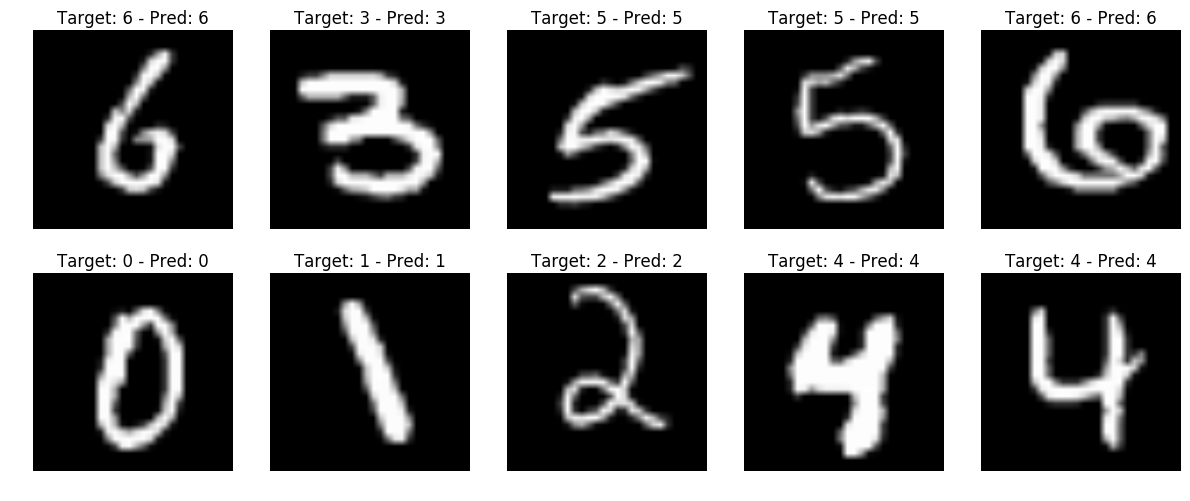

In [79]:
preds =  predict_mnist(model_3,test)
plot_predictions(test, preds, 46)

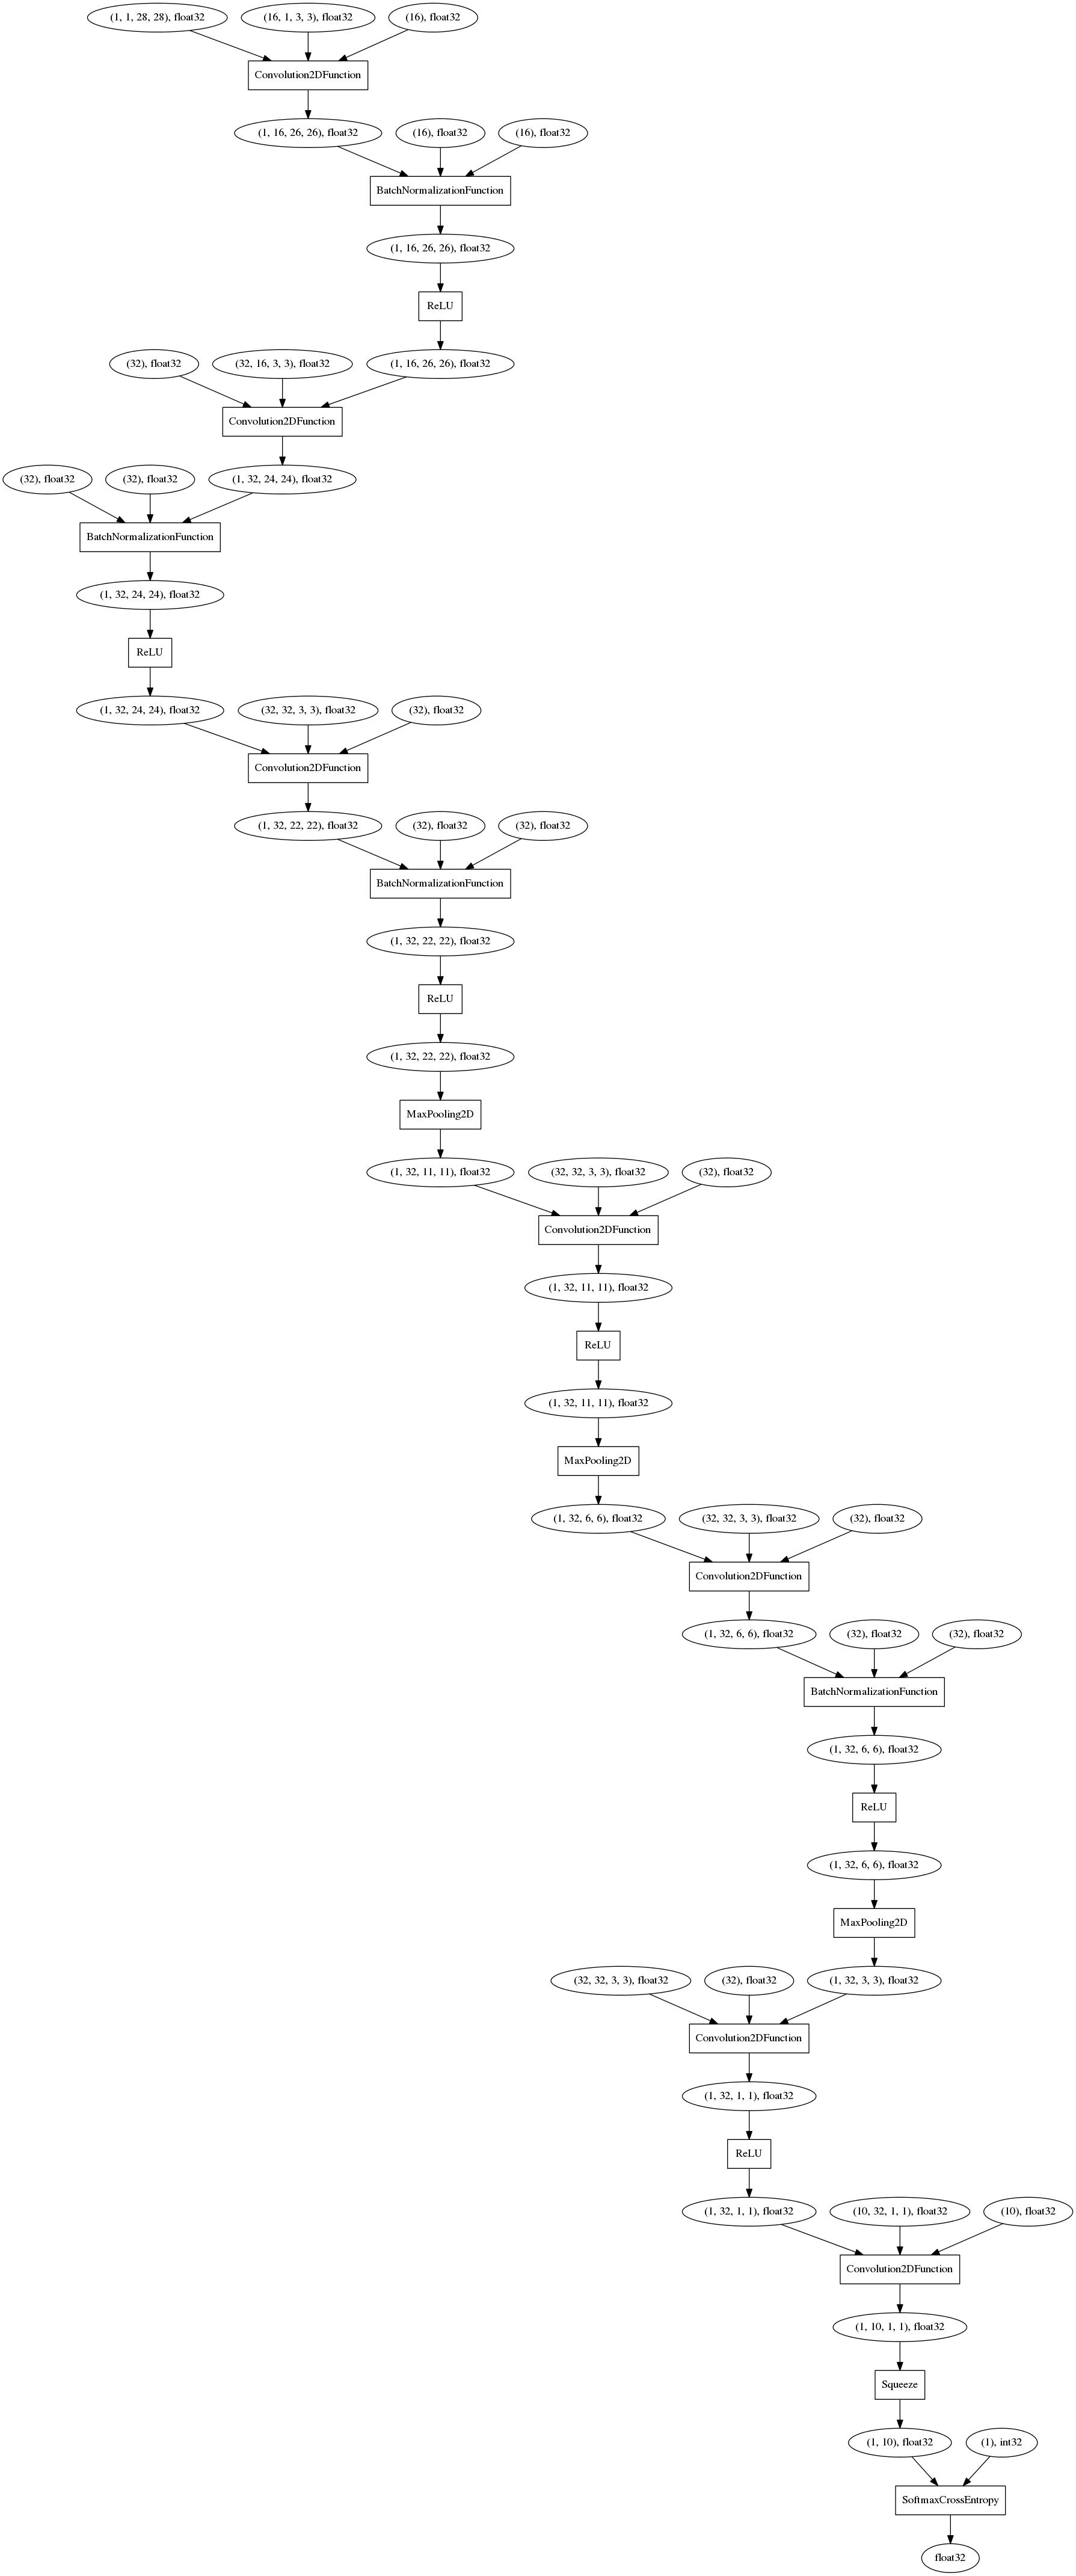

In [80]:
print_network_mnist(model_3_classify,test,toBook=True)

We can also add function hooks that interact with the foward and backward pass of the training process.  
Some useful ones are the *TimerHook()* for timing the evaluation of parts of a model and the *PrintHook()* that prints debug information about parts of a model.

In [81]:
from chainer import function_hooks

In [82]:
x = Variable(cuda.to_gpu((train[0][0]).reshape(1,1,28,28)))
with function_hooks.TimerHook() as t:
    y = model_3(x)
    print(t.total_time())

0.007623935978859664


In [83]:
with function_hooks.PrintHook():
    y = model_3(x)

function	Convolution2DFunction
input data
- device: <CUDA Device 0>
- volatile: OFF
- backend: <class 'cupy.core.core.ndarray'>
- shape: (1, 1, 28, 28)
- dtype: float32
- statistics: mean=0.13768008, std=0.31234837
- grad: None
- device: <CUDA Device 0>
- volatile: OFF
- backend: <class 'cupy.core.core.ndarray'>
- shape: (16, 1, 3, 3)
- dtype: float32
- statistics: mean=0.00792455, std=0.14166792
- grad: None
- device: <CUDA Device 0>
- volatile: OFF
- backend: <class 'cupy.core.core.ndarray'>
- shape: (16,)
- dtype: float32
- statistics: mean=0.01110203, std=0.06203377
- grad: None
function	BatchNormalizationFunction
input data
- device: <CUDA Device 0>
- volatile: OFF
- backend: <class 'cupy.core.core.ndarray'>
- shape: (1, 16, 26, 26)
- dtype: float32
- statistics: mean=0.02249029, std=0.12437081
- grad: None
- device: <CUDA Device 0>
- volatile: OFF
- backend: <class 'cupy.core.core.ndarray'>
- shape: (16,)
- dtype: float32
- statistics: mean=0.98111546, std=0.14712429
- grad: None

For more on chainer from others, see the [chainer external examples](https://github.com/pfnet/chainer/wiki/External-examples).